In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

2022-06-04 13:41:21.923840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 13:41:21.923878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.9.0'

In [3]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/robotautas/kursas/master/Machine%20Learning/heart.csv')

In [4]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
dataframe['ill'] = np.where(dataframe['target']==1, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['target'])


In [6]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [7]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

242 training examples
30 validation examples
31 test examples


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('ill')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [9]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/tmp/ipykernel_8663/1873766861.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2022-06-04 13:41:38.011950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-04 13:41:38.011984: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-04 13:41:38.012012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (T420s): /proc/driver/nvidia/version does not exist


In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
# print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'ill']
A batch of targets: tf.Tensor([1 1 1 0 0], shape=(5,), dtype=int64)


In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
slope_col = train_features['slope']
layer = get_normalization_layer('slope', train_ds)
layer(slope_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.61395437],
       [-0.61395437],
       [-0.61395437],
       [ 1.01876   ],
       [ 1.01876   ]], dtype=float32)>

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [14]:
test_chol_col = train_features['chol']
test_chol_layer = get_category_encoding_layer(name='chol',
                                              dataset=train_ds,
                                              dtype='int64')
test_chol_layer(test_chol_col)

<tf.Tensor: shape=(5, 137), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0

In [15]:
test_exang_col = train_features['exang']
test_exang_layer = get_category_encoding_layer(name='exang',
                                              dataset=train_ds,
                                              dtype='int64')
test_exang_layer(test_exang_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [16]:
test_oldpeak_col = train_features['oldpeak']
test_oldpeak_layer = get_category_encoding_layer(name='oldpeak',
                                              dataset=train_ds,
                                              dtype='int64')
test_oldpeak_layer(test_oldpeak_col)

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [17]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_8663/1873766861.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_8663/1873766861.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [18]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['age', 'sex']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [19]:
ill_col = tf.keras.Input(shape=(1,), name='ill', dtype='int64')

encoding_layer = get_category_encoding_layer(name='ill',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_ill_col = encoding_layer(ill_col)
all_inputs.append(ill_col)
encoded_features.append(encoded_ill_col)

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

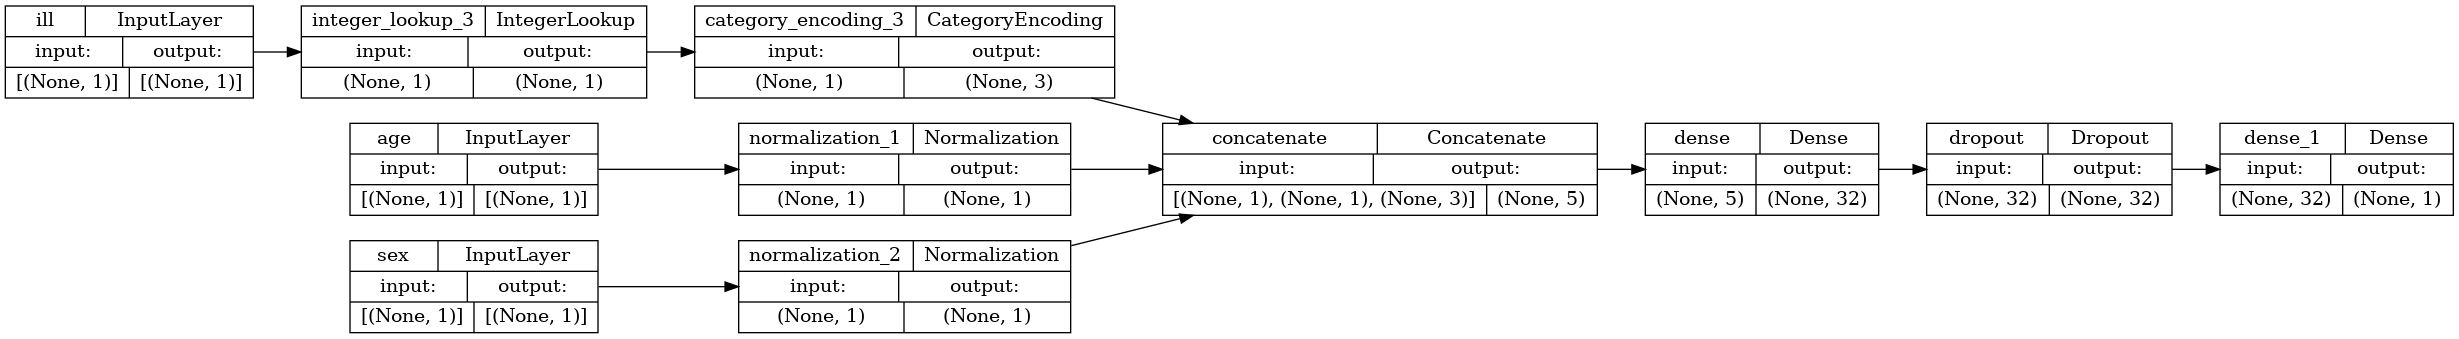

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [23]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/home/dainius/.local/lib/python3.8/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 920ms/step - loss: 0.7567 - accuracy: 0.5083 - val_loss: 0.8476 - val_accuracy: 0.4333
Epoch 2/10
1/1 [==============================] - 0s 23ms/step - loss: 0.7376 - accuracy: 0.5248 - val_loss: 0.8417 - val_accuracy: 0.4333
Epoch 3/10
1/1 [==============================] - 0s 24ms/step - loss: 0.7400 - accuracy: 0.5331 - val_loss: 0.8358 - val_accuracy: 0.4333
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.7158 - accuracy: 0.5579 - val_loss: 0.8299 - val_accuracy: 0.4333
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 0.7383 - accuracy: 0.5496 - val_loss: 0.8242 - val_accuracy: 0.4333
Epoch 6/10
1/1 [==============================] - 0s 28ms/step - loss: 0.7056 - accuracy: 0.5579 - val_loss: 0.8185 - val_accuracy: 0.4667
Epoch 7/10
1/1 [==============================] - 0s 25ms/step - loss: 0.7248 - accuracy: 0.5372 - val_loss: 0.8128 - val_accuracy: 0.4667
Epoch 8/10
1/1 [=====================

In [24]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 17ms/step - loss: 0.7937 - accuracy: 0.5161
Accuracy 0.5161290168762207


In [26]:
model.save('heart_diagnoser')
reloaded_model = tf.keras.models.load_model('heart_diagnoser')

INFO:tensorflow:Assets written to: heart_diagnoser/assets


In [33]:
sample = {
    'age': 35,
    'sex': 1,
    'cp': 0,
    'trestbps': 88,
    'chol': 95,
    'fbs': 1,
    'restecg': 0,
    'thalach': 156,
    'exang': 0,
    'oldpeak': 3.5,
    'slope': 2,
    'ca': 0,
    'thal': 3,
    'ill': 0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular patient has a %.1f percent probability "
    "of positive heart disease diagnosis." % (100 * prob)
)

1/1 [==============================] - 0s 31ms/step
This particular patient has a 79.1 percent probability of positive heart disease diagnosis.
